In [1]:
!pip install -q fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *

# 1. Data loading and augmentation

Create a DataBlock and DataLoaders using:
- Training and validation images collected in Lab2
- `Resize(640)` as item transform
- A size of 420 in the batch transforms
- Use a batch size of 32
- Use `set_seed()` to obtain reproducible results.
- Augmentations you find useful (see question 1)

Show a training and a validation batch.
Show augmentations, i.e. `show_batch()` with `unique=True`.

In [3]:
path = Path('/content/gdrive/MyDrive/Colab Notebooks/digits')

digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items = get_image_files, 
                 splitter = set_seed(42),
                 get_y = parent_label,
                 item_tfms = Resize(640, 'squish'),
                 batch_tfms = aug_transforms(size=420, max_rotate = 90, max_zoom = 0.25, pad_mode= 'border'))
dls = digits.dataloaders(path, bs = 32)


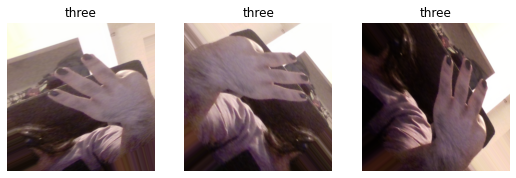

In [4]:
dls.train.show_batch(nrows=1, ncols=3, unique=True)

### Question 1: How did you choose your augmentation transfroms? Include your thought process.
Looking at the docs.fast.ai in data augmentation (aug_transforms):
- instead of using min_scale which addes random resized crop I wanted to do squish
- squish wont crop out fingers so added that in item_tfms
- Dont want flip_vert because detecting american counting system which doesnt have upside down fingers
- set max_rotate to 90 for the same reason
- set max_zoom to 0.25 to limit croping out fingers as well
- didn't want any black space for padding or reflection which could confuse the model on how many digits are shown so used border to blur the edges when needed


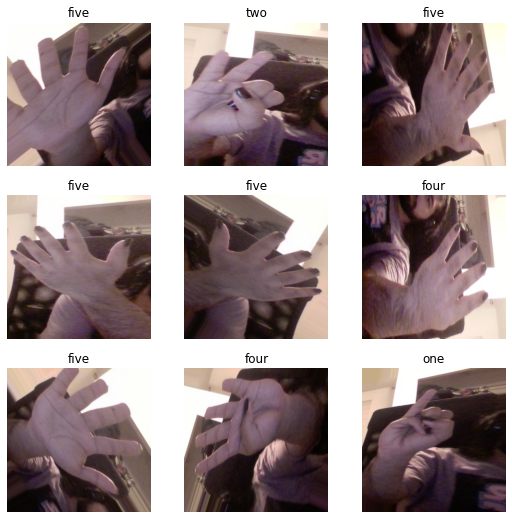

In [5]:
dls.train.show_batch(nrows=3, ncols=3)

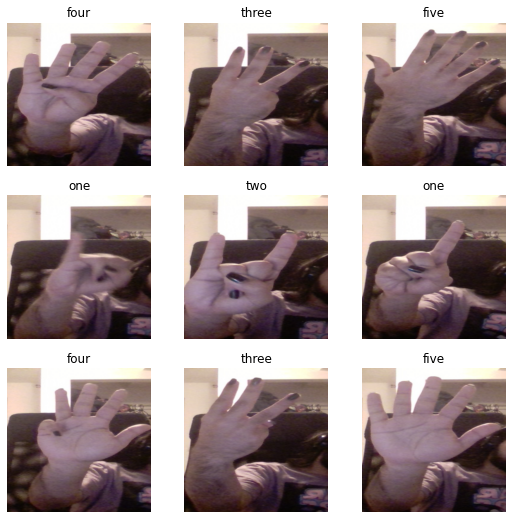

In [6]:
dls.valid.show_batch(nrows=3, ncols=3)

### Question 2: Are there any problems with your augmentations in the training data, or validation data, e.g. fingers missing, etc.?
At first there were issues with missing fingers but when I added squish into item_tfms that was no longer an issue. I don't see any issues but that may be from inexperience.


# 2. Train the classifier

## 2.1 Train a fastai cnn multi-class classifier
- ResNet18 architecture.
- accuracy as metric.
- learning rate finder to find initial learning rate.
- transfer learning with unfreezing using descriminative learning rates.
- use a batch size of 32 and the DataBlock from above.
- Use the same `set_seed()` as above to obtain reproducible results.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

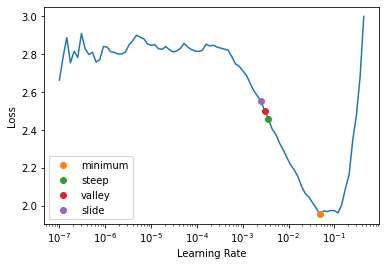

In [7]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [8]:
print(f"Minimum/10:\t{lr_min:.2e}\nSteepest point:\t{lr_steep:.2e}\nLongest valley:\t{lr_valley:.2e}\nSlide interval:\t{lr_slide:.2e}")

Minimum/10:	4.79e-03
Steepest point:	3.63e-03
Longest valley:	3.02e-03
Slide interval:	2.51e-03


In [9]:
learn.fine_tune(1, base_lr=0.1) # see how it would be out of box

epoch,train_loss,valid_loss,accuracy,time
0,2.771991,32.599808,0.180000,00:08


epoch,train_loss,valid_loss,accuracy,time
0,6.152232,165.971207,0.260000,00:05


In [10]:
learn.fine_tune(1, base_lr=7e-4) 
# accuracy does better than lr of 0.1

epoch,train_loss,valid_loss,accuracy,time
0,3.978632,9.952182,0.280000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,4.238281,3.500345,0.240000,00:05


In [11]:
# transfer learning
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(2, 7e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.577457,2.264682,0.220000,00:05
1,2.527315,1.786923,0.260000,00:05


SuggestedLRs(valley=0.0002290867705596611)

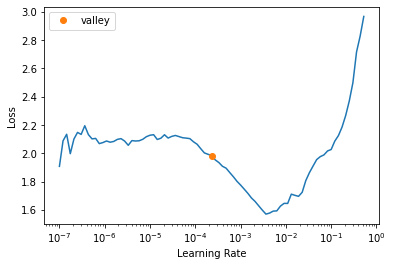

In [12]:
# unfreeze and find learning rate with different landscape
learn.unfreeze()
learn.lr_find()

In [13]:
learn.fit_one_cycle(4, lr_max=3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.092952,1.674557,0.340000,00:06
1,1.837146,2.048971,0.420000,00:06
2,1.658282,2.154129,0.380000,00:06
3,1.512952,1.258741,0.580000,00:06


In [14]:
# discrimnative learning rates
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(2, 7e-4)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(7e-5,7e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.593987,2.531994,0.200000,00:05
1,2.396355,1.725911,0.380000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,2.059556,1.333922,0.560000,00:06
1,1.665109,1.391558,0.620000,00:06
2,1.374277,2.128381,0.560000,00:06
3,1.275050,2.945605,0.620000,00:06
4,1.104648,4.523015,0.500000,00:06
5,0.979239,1.147374,0.740000,00:06
6,0.859536,0.835893,0.780000,00:06
7,0.760506,0.526035,0.840000,00:06
8,0.659228,0.190022,0.960000,00:06
9,0.580991,0.097667,0.980000,00:06


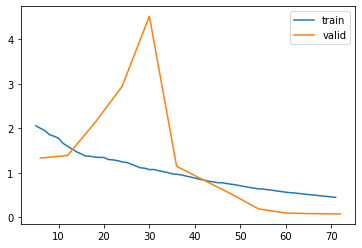

In [15]:
learn.recorder.plot_loss()  #valid loss spikes

### Question 3: How did you select the number of epochs and learning rates? 
- Initial learning rate: used a vlaue slightly less than the valley point shown using the learning rate finder (7e-4).
- unfrozen layer learning rate: unfroze layers then did learning rate finder again. chose a point close to the valley (3e-4)
- epochs: trained for more epochs, when saw diverging or a plateau in accuracy I went lower (12)



## 2.2 Experiment with different batch sizes
Using the pipeline, number of epochs, learning rates from above, re-run the pipeline with a batch size of 16, 64

In [16]:
# size of 16
dls = digits.dataloaders(path, bs = 16)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(2, 7e-4)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(7e-5,7e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.550363,1.491062,0.440000,00:05
1,2.456125,1.084170,0.640000,00:06


epoch,train_loss,valid_loss,accuracy,time
0,1.797268,0.713304,0.680000,00:06
1,1.579764,1.787312,0.640000,00:05
2,1.444121,1.575161,0.780000,00:05
3,1.455898,0.440751,0.880000,00:05
4,1.407904,0.376483,0.880000,00:05
5,1.205970,0.669779,0.880000,00:05
6,1.041873,0.138041,0.940000,00:05
7,0.934496,0.226891,0.940000,00:05
8,0.787616,0.088674,0.980000,00:06
9,0.626522,0.124198,0.980000,00:05


In [17]:
# size of 64
dls = digits.dataloaders(path, bs = 64)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(2, 7e-4)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(7e-5,7e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.682348,3.971023,0.220000,00:06
1,2.710485,2.876285,0.180000,00:06


epoch,train_loss,valid_loss,accuracy,time
0,2.207431,1.973352,0.380000,00:07
1,1.902212,2.426329,0.340000,00:07
2,1.606155,0.742928,0.720000,00:07
3,1.410590,3.650319,0.500000,00:07
4,1.285145,0.611404,0.760000,00:07
5,1.143301,0.595163,0.860000,00:07
6,1.029505,0.122681,0.960000,00:07
7,0.918814,0.027335,1.000000,00:06
8,0.821447,0.012026,1.000000,00:07
9,0.744182,0.006274,1.000000,00:07


### Question 4: Keeping number of epochs and learning rates the same, how are validation loss and accuracy effected by the increase and decrease of batch size? 
Decrease in batch size (16):
- validation loss: has a weird jump at the second epoch then continues to decrease
- accuracy: slight dip on the 2nd epoch, plateaus between 4-6, increases and plateaus again from 9th epoch till the end.(might be overfitting)

Increase in batch size (64):
- validation loss: overall decreases with a sudden jump at the 4th epoch and a small one at the 2nd
- accuracy: dips at 2nd and 4th epoch, steady increase.


# 3. Analyze model performance
Retrain the model with batch size of 32 from the previous section.

Plot the confusion matrix.

In [18]:
dls = digits.dataloaders(path, bs = 32)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(2, 7e-4)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(7e-5,7e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.710635,2.819362,0.200000,00:05
1,2.485568,1.735464,0.240000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,2.038727,1.249275,0.440000,00:06
1,1.688097,0.691613,0.700000,00:06
2,1.424530,1.352764,0.720000,00:06
3,1.294691,1.580427,0.720000,00:06
4,1.110256,1.408964,0.700000,00:06
5,0.945053,0.278284,0.900000,00:06
6,0.835454,0.114617,0.960000,00:06
7,0.749257,0.099992,0.960000,00:06
8,0.656485,0.042443,0.980000,00:06
9,0.579479,0.016546,1.000000,00:06


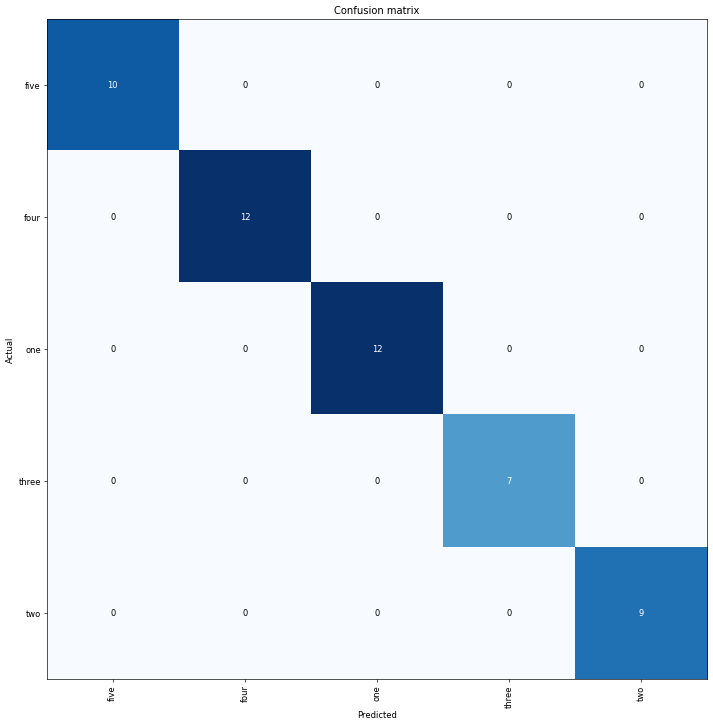

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [20]:
interp.most_confused(min_val=1)

[]

# 4. Save the best model to file
Save the model using `learn.export()` as `.pkl` file. Verify that the model can be reloaded and used to make predictions.

In [21]:
export_path = Path('/content/gdrive/MyDrive/Colab Notebooks')

if not (export_path/'models').exists():
  (export_path/'models').mkdir()

In [22]:
learn.export(fname=(export_path/"models/digits_model.pkl"))
(export_path/"models").ls()

(#1) [Path('/content/gdrive/MyDrive/Colab Notebooks/models/digits_model.pkl')]

# 5. Summary and Conclusion

Summarize:
- Augmentations used:
  - squish
  - max_rotat = 90
  - max_zoom = 0.25 
  - pad_mode = 'border'
These augmentations limited the cutting off of fingers so no digits were missing and they didnt introduce the posibility of thinking there were extra digits.
- Training strategy:
  - lr finder to find inital lr = 7e-4
  - Transfer learning, fit_one_cycle with lr = 7e-4
  - unfreeze and use lr finder again with different landscape
  - do fit_one_cycle with new lr = 3e-4
  THEN
  - Discriminative learning: fit_one_cycle with inital lr (7e-4)
  - unfreeze
  - fit_one_cycle with slice (earliest layer gets 7e-5 and last with 7e-3)
  - batch size = 32 (performed the best compared to 64 and 16)
  - epochs = 12 (more started diverging)

- Accuracy achieved = 100%
  - summary of confusion matrix: No inaccurate predictions


Conclusion:
- yes I am satisfied with the performance of the model. An accuracy of 100% is quite good while the training loss and validation loss plateau at the end.


# 6.Reflection
Include a sentence or two about
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating

while working on this assignment.

- I liked how I got to tune my own model and see how it improved or got worse as I changed things
- I liked how this was all from scratch and its turning into an NN!
- I think I messed up on the set_seed part but Im not sure 
